<a href="https://colab.research.google.com/github/kkt86/quant-notebooks/blob/master/lstm_asx_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock market predictions for Australian Securities Exchange (ASX) with LSTM network

In this notebook, we reimplement the code from the following link:
https://towardsdatascience.com/predicting-the-movement-of-stocks-in-the-australian-securities-exchange-asx-fa63b5c059bb

Repository:
https://github.com/arvindrajan92/asx-financial-time-series-prediction

Open questions:

1. Does 75th percentile on full data have impact (test on a training period only)
2. Try normalizing on columns only
3. Try not to balance UPs and DOWNs


In [1]:
### copy data from repository
%%bash
git clone https://github.com/arvindrajan92/asx-financial-time-series-prediction



Cloning into 'asx-financial-time-series-prediction'...


In [0]:
# produce 5 dataframes: open, high, low, close and volume with index the date, and colums the indexs
import glob
import pandas as pd
import numpy as np

directory = "asx-financial-time-series-prediction/ASX-2015-2018/ASX-2015-2018/"
files = glob.glob(directory + "[0-9]*.txt") 
cols = ["ticker", "date", "open", "high", "low", "close", "volume"]

dfs = [pd.read_csv(file, header=None, names=cols, parse_dates=["date"], index_col="date") for file in files]

df_master = pd.concat(dfs)
df_master = df_master.sort_index()

In [3]:
# print number of tickets and dates
print(f"Number of distinct tickers: {len(df_master.ticker.unique())}")
print(f"Number of days entries: {len(df_master.index.unique())}")
print(f"First day of entry: {df_master.index.min()}")
print(f"Last day of entry: {df_master.index.max()}")

Number of distinct tickers: 2773
Number of days entries: 883
First day of entry: 2015-01-02 00:00:00
Last day of entry: 2018-06-29 00:00:00


In [0]:
# build dataframes for open, high, low, close and volume
df_master.head()

df_open = df_master[["ticker", "open"]].pivot(columns="ticker", values="open")
df_high = df_master[["ticker", "high"]].pivot(columns="ticker", values="high")
df_low = df_master[["ticker", "low"]].pivot(columns="ticker", values="low")
df_close = df_master[["ticker", "close"]].pivot(columns="ticker", values="close")
df_volume = df_master[["ticker", "volume"]].pivot(columns="ticker", values="volume")

# compute the next day return and assign it to the current date
df_ftr_rtn = df_close.shift(-1) / df_close - 1

# find the current day return (compared to the last day)
df_rtn = (df_close / df_close.shift(1)) - 1

# create dataframe for the high/low values, for each day
df_hl = df_high/df_low

### EDA

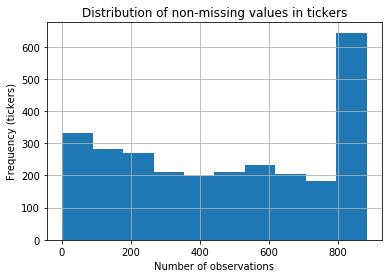

There are 196 tickers with full data available


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# histogram of the number of the number of non-missing values
ax = df_close.notna().sum().hist()
plt.xlabel("Number of observations")
plt.ylabel("Frequency (tickers)")
plt.axis("tight")
plt.title("Distribution of non-missing values in tickers")
plt.show()

print(f"There are {df_close.columns[df_close.notna().sum() == df_close.shape[0]].shape[0]} tickers with full data available")

In [0]:
# find and remove composite indexes (those wiht volume = 0)
non_composite_indexes = df_volume.columns[(df_volume.notna().sum() != 0).values].values

df_open = df_open[non_composite_indexes]
df_high = df_high[non_composite_indexes]
df_low = df_low[non_composite_indexes]
df_close = df_close[non_composite_indexes]
df_volume = df_volume[non_composite_indexes]
df_ftr_rtn = df_ftr_rtn[non_composite_indexes]
df_rtn = df_rtn[non_composite_indexes]
df_hl = df_hl[non_composite_indexes] 

In [0]:
# remove tickers with less than 800 entries
tickers_good = df_close.columns[(df_close.notna().sum() >= 800).values].values

df_open = df_open[tickers_good]
df_high = df_high[tickers_good]
df_low = df_low[tickers_good]
df_close = df_close[tickers_good]
df_volume = df_volume[tickers_good]
df_ftr_rtn = df_ftr_rtn[tickers_good]
df_rtn = df_rtn[tickers_good]
df_hl = df_hl[tickers_good] 

__Note__: the author is considering tickers, whose correlation with the future return is in the top 75 percent. I believe this introduces quite a strong look ahead bias. For this reason, I will implement the following 3 cases:

1. Original implementation (filtering done on the full data)
2. Train dataset filtering (computation of the average correlation done only on training data)
3. No filtering

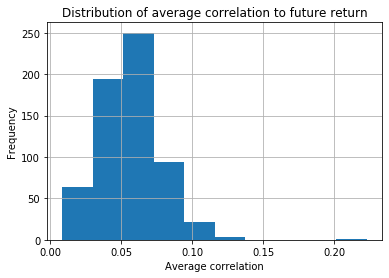

In [8]:
# rank tickers by average correlation
df_corr_score  = pd.DataFrame()

for ticker in tickers_good:
  df = pd.concat([df_open[ticker], 
                  df_high[ticker], 
                  df_low[ticker], 
                  df_close[ticker], 
                  df_volume[ticker], 
                  df_ftr_rtn[ticker], 
                  df_rtn[ticker], 
                  df_hl[ticker]], axis=1, keys=["open", "high", "low", "close", "volume", "future_return", "return", "high_low"])
  df_corr_score = df_corr_score.append({"ticker": ticker, 
                                        "avg_corr": df.corr().drop("future_return", axis=1).loc["future_return"].abs().mean()}, 
                                       ignore_index=True)
  
# plot average correlations
df_corr_score.avg_corr.hist()
plt.xlabel("Average correlation")
plt.ylabel("Frequency")
plt.title("Distribution of average correlation to future return")
plt.show()

In [0]:
case = "original"
assert case in ["original", "train-data", "no-filter"], "Wrong case value"

if case == "original":
  tickers_75 = df_corr_score[df_corr_score.avg_corr > df_corr_score.avg_corr.quantile(0.75)].ticker.values

  # get only filtered data
  df_open = df_open[tickers_75]
  df_high = df_high[tickers_75]
  df_low = df_low[tickers_75]
  df_close = df_close[tickers_75]
  df_volume = df_volume[tickers_75]
  df_ftr_rtn = df_ftr_rtn[tickers_75]
  df_rtn = df_rtn[tickers_75]
  df_hl = df_hl[tickers_75]

#elif case == "no-train-data":

#else:

In [0]:
# clean original data
df_close = df_close.fillna(method="ffill")
df_close = df_close.fillna(method="bfill")
df_volume = df_volume.apply(lambda x: 0 if pd.isna(x) is True else x)
df_open = df_open.fillna(df_close)
df_high = df_high.fillna(df_close)
df_low = df_low.fillna(df_close)
df_ftr_rtn = (df_close.shift(-1) / df_close) - 1 
df_rtn = (df_close / df_close.shift(1)) - 1 
df_hl = df_high/df_low

## Additional transformations

In [11]:
%pip install ta

  Created wheel for ta: filename=ta-0.5.11-cp36-none-any.whl size=23029 sha256=7c19011adadc50a11702c4efc755911d211172c509d99b58b347be213dcc44be
  Stored in directory: /root/.cache/pip/wheels/97/32/1d/cbc724a8ecaec6e426baf57ab8c4c2cdc687aadd7427280b1f
Successfully built ta


In [0]:
import ta

# mfi dataframe
df_mfi = pd.DataFrame(index=df_close.index)

for ticker in df_close.columns:
  temp = ta.momentum.money_flow_index(high=df_high[ticker], 
                                      low=df_low[ticker], 
                                      close=df_close[ticker], 
                                      volume=df_volume[ticker], 
                                      fillna=True)
  df_mfi = pd.concat([df_mfi, temp], axis=1)

df_mfi.columns = df_close.columns

In [0]:
# ema dataframe
df_ema = df_close.apply(ta.trend.ema_indicator, fillna=True)

In [0]:
# rsi dataframe
df_rsi = df_close.apply(ta.momentum.rsi, fillna=True)

In [0]:
# stock_k and stock_d dataframes
df_stock_k = pd.DataFrame(index=df_close.index)
df_stock_d = pd.DataFrame(index=df_close.index)

for ticker in df_close.columns:
  temp = ta.momentum.stoch(high=df_high[ticker], 
                           low=df_low[ticker], 
                           close=df_close[ticker], 
                           fillna=True)
  df_stock_k = pd.concat([df_stock_k, temp], axis=1)

  temp = ta.momentum.stoch_signal(high=df_high[ticker], 
                                  low=df_low[ticker], 
                                  close=df_close[ticker], 
                                  fillna=True)
  df_stock_d = pd.concat([df_stock_d, temp], axis=1)

df_stock_k.columns = df_close.columns
df_stock_d.columns = df_close.columns

In [0]:
# macd dataframe
df_macd = df_close.apply(ta.trend.macd_diff, fillna=True)

In [0]:
# william_r dataframe
df_will_r = pd.DataFrame(index=df_close.index)

for ticker in df_close.columns: 
  temp = ta.momentum.wr(high=df_high[ticker], 
                        low=df_low[ticker], 
                        close=df_close[ticker], 
                        fillna=True)
  df_will_r = pd.concat([df_will_r, temp], axis=1)

df_will_r.columns = df_close.columns

In [0]:
# cci dataframe
df_cci = pd.DataFrame(index=df_close.index)

for ticker in df_close.columns: 
  temp = ta.trend.cci(high=df_high[ticker], 
                      low=df_low[ticker], 
                      close=df_close[ticker], 
                      fillna=True)
  df_cci = pd.concat([df_cci, temp], axis=1)

df_cci.columns = df_close.columns

In [0]:
# ichi_a and ichi_b dataframe
df_ichi_a = pd.DataFrame(index=df_close.index)
df_ichi_b = pd.DataFrame(index=df_close.index)

# loop over all tickers
for ticker in df_close.columns:
    # calculate ichi_a
    temp = ta.trend.ichimoku_a(high=df_high[ticker],
                               low=df_low[ticker],
                              fillna=True)
    # concatenate with main dataframe
    df_ichi_a = pd.concat([df_ichi_a, temp], axis=1)
    
    # calculate ichi_b
    temp = ta.trend.ichimoku_b(high=df_high[ticker],
                               low=df_low[ticker],
                              fillna=True)
    # concatenate with main dataframe
    df_ichi_b = pd.concat([df_ichi_b, temp], axis=1)

# rename the columns
df_ichi_a.columns = df_close.columns
df_ichi_b.columns = df_close.columns

In [0]:
# A/D dataframe
df_ad = pd.DataFrame(index=df_close.index)

# loop over all tickers
for ticker in df_close.columns:
    # calculate cci
    temp = ta.volume.acc_dist_index(high=df_high[ticker],
                                    low=df_low[ticker],
                                    close=df_close[ticker],
                                    volume=df_volume[ticker],
                                    fillna=True
                                   )
    # concatenate with main dataframe
    df_ad = pd.concat([df_ad, temp], axis=1)

# rename the columns
df_ad.columns = df_close.columns

In [0]:
# Calculate upper and lower band
df_bb_up = df_close.apply(ta.volatility.bollinger_hband, fillna=True)
df_bb_down = df_close.apply(ta.volatility.bollinger_lband, fillna=True)

## Train/Validation/Test split

In [0]:
# create lists of dataframes and their names
dataframes = [df_open, df_high, df_low, df_close, df_volume, df_rtn, df_hl,
              df_mfi, df_ema, df_rsi, df_stock_k, df_stock_d, df_macd, df_will_r, df_cci,
              df_ichi_a, df_ichi_b, df_ad, df_bb_up, df_bb_down, df_ftr_rtn]
names = ["open", "high", "low", "close", "volume", "rtn", "hl",
         "mfi", "ema", "rsi", "stock_k", "stock_d", "macd", "will_r", "cci",
         "ichi_a", "ichi_b", "ad", "bb_up", "bb_down", "ftr_rtn"]

assert len(dataframes) == len(names), "Length is not the same"

# remove dates prior to 2015-02-01 and date 2018-06-29
dataframes = [df[df.index >= "2015-02-01"] for df in dataframes]
dataframes = [df[df.index != "2018-06-29"] for df in dataframes]

In [0]:
# create a correlation headmap of the average correlations between features
import seaborn as sns

corr_val = np.empty([len(dataframes), len(dataframes)])

# loop over each dataframe and find correlation
for i, df1 in enumerate(dataframes):
  for j, df2 in enumerate(dataframes):
    corr_val[i][j] = df1.corrwith(df2).mean()

Text(0.5, 1, 'Average correlation heatmap')

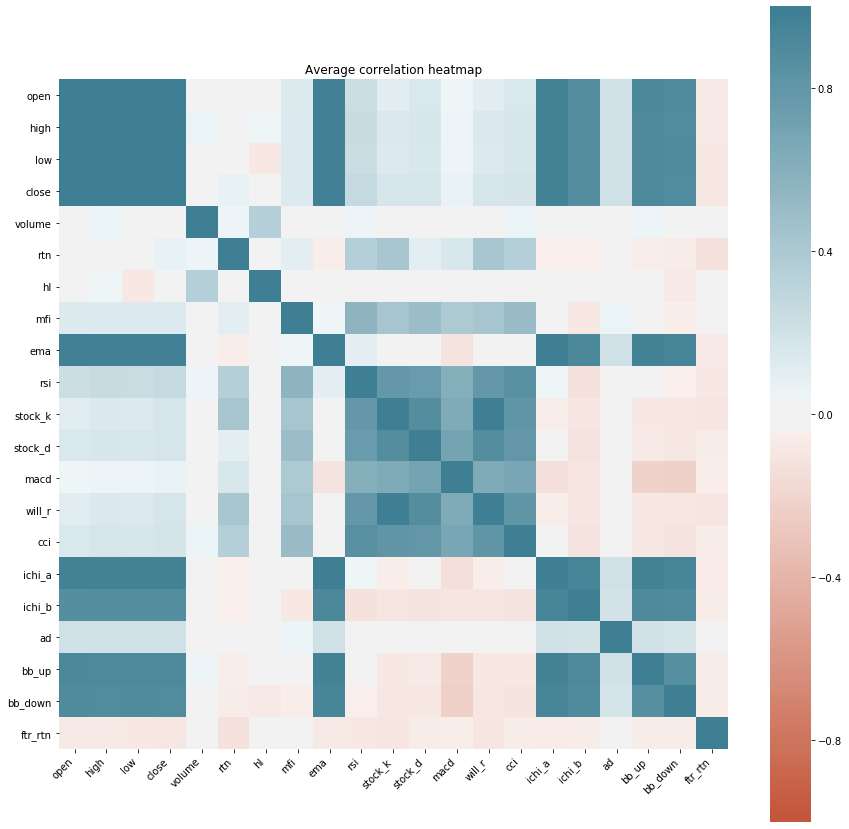

In [24]:
# plot correlation matrix
fig, ax = plt.subplots(figsize=(15, 15))
df_corr = pd.DataFrame(corr_val, columns=names, index=names)

sns.heatmap(df_corr, vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(20, 220, n=500), 
            square=True, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.set_title("Average correlation heatmap")

__Note__: baed on correlation and outliers reasoning, the following features will be included: close, rtn, ema, rsi, stoch_k, stock_d, macd, cci, ichi_a, ichi_b, bb_up, bb_down

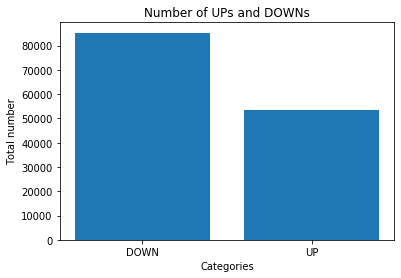

In [25]:
# create a target variable
df_target = (df_ftr_rtn > 0).astype(int)

# Look at the proportion
values, counts = np.unique(df_target.values.reshape(df_target.shape[0]*df_target.shape[1]), return_counts=True)
plt.bar(values,counts,tick_label=['DOWN','UP'])
plt.title('Number of UPs and DOWNs')
plt.ylabel('Total number')
plt.xlabel('Categories')
plt.show()

In [0]:
# create final list of features and their names
dataframes = [df_close, df_rtn, df_ema, df_rsi, df_stock_k, df_stock_d, df_macd, df_cci,
              df_ichi_a, df_ichi_b, df_bb_up, df_bb_down, df_target]
names = ["close", "rtn", "ema", "rsi", "stock_k", "stock_d", "macd", "cci",
         "ichi_a", "ichi_b", "bb_up", "bb_down", "target"]

assert len(dataframes) == len(names)

# Training

In [0]:
# create training, evaluation and testing dataframes
dataframes_train = []
dataframes_eval = []
dataframes_test = []
for df in dataframes:
  dataframes_train.append(df.iloc[df.index < "2017-07-01"])
  dataframes_eval.append(df.iloc[(df.index >= "2017-07-01") & (df.index < "2018-01-01")])
  dataframes_test.append(df.iloc[df.index >= "2018-01-01"])

In [0]:
from sklearn.preprocessing import MinMaxScaler

# define normalizers
normalizers = []

for i, df in enumerate(dataframes_train[:-1]):
  # create normalizer object
  normalizers.append(MinMaxScaler(feature_range=(0,1)))

  # columns and indexes
  columns = dataframes_train[i].columns
  index_train = dataframes_train[i].index
  index_eval = dataframes_eval[i].index
  index_test = dataframes_test[i].index

  # fit normalizer
  normalizers[i].fit(dataframes_train[i])

  # transform
  train_data = normalizers[i].transform(dataframes_train[i])
  eval_data = normalizers[i].transform(dataframes_eval[i])
  test_data = normalizers[i].transform(dataframes_test[i])

  # replace lists
  dataframes_train[i] = pd.DataFrame(train_data, columns=columns, index=index_train)
  dataframes_eval[i] = pd.DataFrame(eval_data, columns=columns, index=index_eval)
  dataframes_test[i] = pd.DataFrame(test_data, columns=columns, index=index_test)

In [0]:
# scale data to have mean 0 and unit variance
from sklearn.preprocessing import StandardScaler

# define scalers
scalers = []

for i, df in enumerate(dataframes_train[:-1]):
  # create scalers object
  scalers.append(StandardScaler())

  # columns and indexes
  columns = dataframes_train[i].columns
  index_train = dataframes_train[i].index
  index_eval = dataframes_eval[i].index
  index_test = dataframes_test[i].index

  # fit scaler
  flat_arr = dataframes_train[i].values.reshape(dataframes_train[i].shape[0]*dataframes_train[i].shape[1], 1)
  scalers[i].fit(np.tile(flat_arr, dataframes_train[i].shape[1]))

  # transform
  train_data = scalers[i].transform(dataframes_train[i])
  eval_data = scalers[i].transform(dataframes_eval[i])
  test_data = scalers[i].transform(dataframes_test[i])

  # replace lists
  dataframes_train[i] = pd.DataFrame(train_data, columns=columns, index=index_train)
  dataframes_eval[i] = pd.DataFrame(eval_data, columns=columns, index=index_eval)
  dataframes_test[i] = pd.DataFrame(test_data, columns=columns, index=index_test)

Now, as data is scaled and normalized, it has to be transformed into a form, suitable for a network to be trained. 60 days of lookback period is used

In [0]:
from collections import deque
import random

SEQ_LEN = 60

def sequence_data(df_list, shuffle=True):
    # list containing the data
    sequential_data = []

    for ticker in df_close.columns:
        # initialise dataframe
        df_ticker = pd.DataFrame()

        # concatenate the dataframes
        for df in df_list:
            df_ticker = pd.concat([df_ticker, df[ticker]], axis=1)

        prev_days = deque(maxlen=SEQ_LEN)
        # for values in every row
        for i in df_ticker.values: 
            # remove the targets
            prev_days.append([n for n in i[:-1]])  
            # append when sequence length is reached
            if len(prev_days) == SEQ_LEN: 
                sequential_data.append([np.array(prev_days), i[-1]])
                
        # shuffle - we do not need to do this for test set
        if shuffle == True:
            random.shuffle(sequential_data)

    return sequential_data


In [31]:
# sequence all datasets
sequential_data_train = sequence_data(dataframes_train)
sequential_data_eval = sequence_data(dataframes_eval)
sequential_data_test = sequence_data(dataframes_test, shuffle=False)

print(f"Training data length: {len(sequential_data_train)}")
print(f"Evaluation data length: {len(sequential_data_eval)}")
print(f"Testing data length: {len(sequential_data_test)}")

Training data length: 89804
Evaluation data length: 10833
Testing data length: 10205


In [0]:
# define function for balancing the data
def balance_data(sequential_data):
  ups = []
  downs = []

  # separate the sequences into ups and downs
  for seq, target in sequential_data:
    if target == 0:
      downs.append([seq, target])
    elif target == 1:
      ups.append([seq, target])

  # shuffle to randomize
  random.shuffle(ups)
  random.shuffle(downs)

  # get shorter length
  lower = min(len(ups), len(downs))

  # truncate lists to the shorter one
  ups = ups[:lower]
  downs = downs[:lower]

  sequential_data = ups + downs
  random.shuffle(sequential_data)

  return sequential_data

# define function for separating train features from target
def separate_data(sequential_data):
  X = []
  y = []
  for seq, target in sequential_data:
    X.append(seq)
    y.append(target)

  return np.array(X), y

In [0]:
train_x, train_y = separate_data(balance_data(sequential_data_train))
validation_x, validation_y = separate_data(balance_data(sequential_data_eval))

In [34]:
# define model
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

BATCH_SIZE = 64
EPOCHS = 40

model = Sequential()

model.add(LSTM(128, input_shape=(train_x.shape[1:]), activation="tanh", return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, activation="tanh", return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, activation="tanh"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6), 
              metrics=["accuracy"])

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           72192     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 128)           512       
_________________________________________

In [0]:
# train model for 20 epochs
history1 = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=20, validation_data=(validation_x, validation_y))
model.save("model_1.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 69196 samples, validate on 8664 samples
Epoch 1/20
20480/69196 [=======>......................] - ETA: 3:00 - loss: 0.6976 - acc: 0.4998

In [0]:
# train model for another 20 epochs
history2 = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=20, validation_data=(validation_x, validation_y))
model.save("model_2.h5")

In [0]:
train_x.shape